<h1>Ring Plot<h1>

<h3>Import<h3>

In [1]:
# IMPORTS

import numpy as np
import pandas as pd

import math as m

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h3>Input data<h3>

In [2]:
filename = './input'
with open(filename, 'r') as f:
    for line in f:
        print(line)

&INPUT

  V_S = 100,                                          ! Voltage over the gap in volts

  BOX_DIM = 0.0d0, 0.0d0, 10.0d0,                    ! Simulations unit size in nano-meter, last number is gap spacing. Others ignored

  TIME_STEP = 1.25d-4,                                ! Size of the time step in pico-seconds

  STEPS = 2000,                                      ! Number of steps to do in the simulation

  EMISSION_MODE = 10,                                  ! Emission mode, field emission = 10, space charge limited = 1, thermal field emission = 9

  NREMIT = 1,                                         ! Number of emitters in the system

  IMAGE_CHARGE = .True.,                              ! True means use image charge effects

  N_IC_MAX = 1,                                       ! Number of image charge partners to use

  COLLISIONS = .False.,                               ! Ion collisions with N2, still in development

  T_temp = 293.15d0,                              

In [3]:
epsilon_0 = 8.854187817e-12
q = 1.60217662e-19
V = 10000
D = 1000*1e-9

t = m.sqrt(q*D/(m.pi*epsilon_0*V))*1e9
print(f'Thickness of ring emitter: ', t)

Thickness of ring emitter:  0.7589372924232792


In [4]:
def ave_min(data):
    '''Find the average minimum angle from each point to its nearest neighbour'''
    # Calculate the distance between each point
    min_dist = 0
    for i in range(len(data)):
        min_dist += data.iloc[i]['dist']
    ave_min_dist = min_dist/len(data)*1e9
    return ave_min_dist

<h3>Sample plot<h3>

Average minimum distance: 6.094632068722416 nm


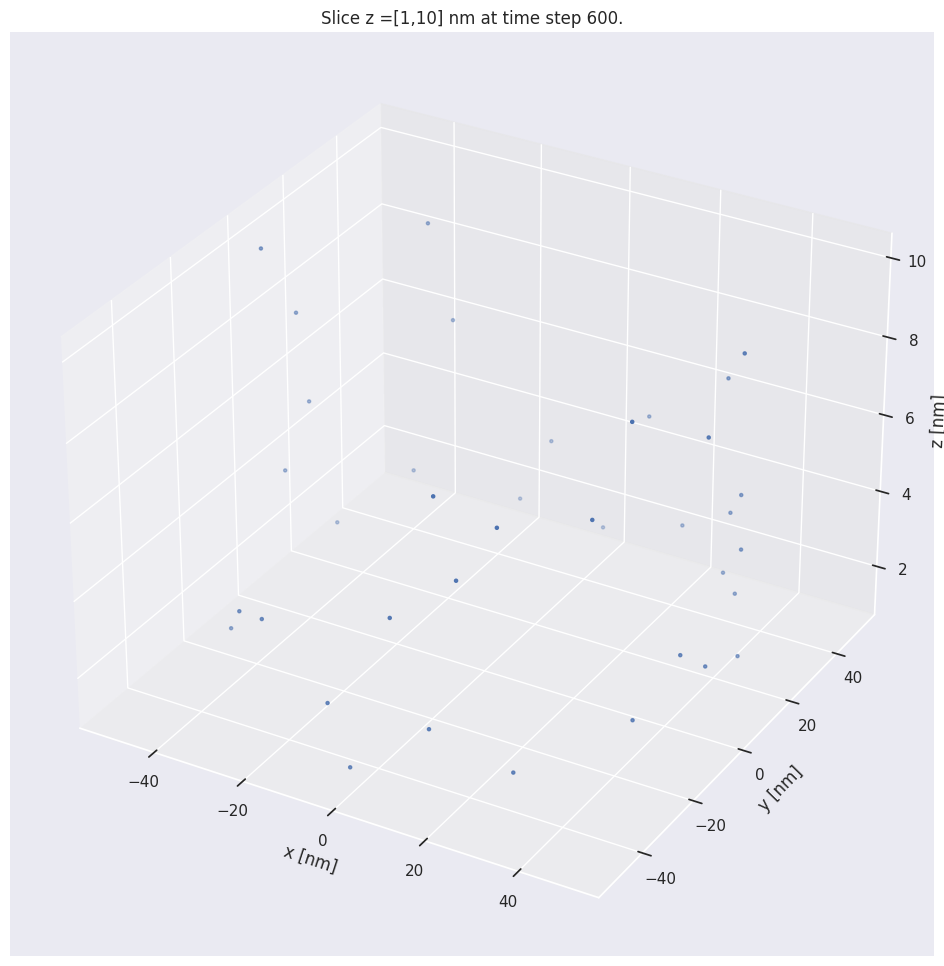

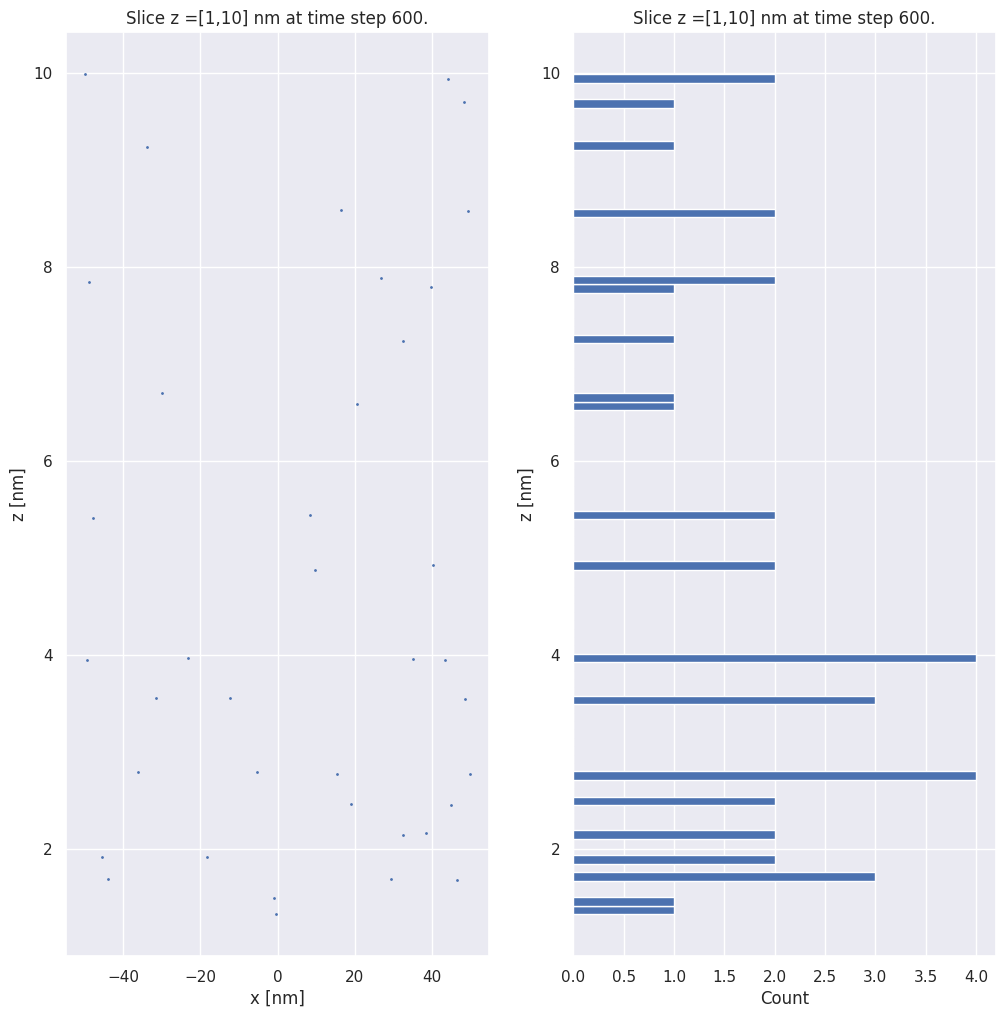

In [5]:
# Input parameters
low = 0 # low z value of slice in nm (0 for ignore)
high = 10 # high z value of slice in nm(0 for ignore)
time_step = 600 # time step of sample

# Memory map file
filename = f'./out/elec-{time_step}.bin'
dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('dist', np.float64)])
data_mem_abs = np.memmap(filename, dtype=dt_abs_type, mode='r', order='F')
    
# Read the data into dataframe 
sample_data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)
if high == 0: high = m.ceil(sample_data['z'].max()*1e9)
if low == 0: low = m.floor(sample_data['z'].min()*1e9)
slice_data = sample_data[(sample_data['z'] > low*1.0e-9) & (sample_data['z'] < high*1.0e-9)]

avg_min_dist = ave_min(slice_data)
print(f'Average minimum distance: {avg_min_dist} nm')

# 3D plot of sample data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(slice_data['x']*1e9, slice_data['y']*1e9, slice_data['z']*1e9, s=5)
ax.set_xlabel('x [nm]')
ax.set_ylabel('y [nm]')
ax.set_zlabel('z [nm]')
ax.set_title(f'Slice z =[{low},{high}] nm at time step {time_step}.')
plt.show()

# 2D plot of sample data with density plot
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(121)
ax1.scatter(slice_data['x']*1e9, slice_data['z']*1e9, s=1)
ax1.set_xlabel('x [nm]')
ax1.set_ylabel('z [nm]')
ax1.set_title(f'Slice z =[{low},{high}] nm at time step {time_step}.')

ax2 = fig.add_subplot(122)
ax2.hist(slice_data['z']*1e9, bins=max(high-low,100), orientation='horizontal')
ax2.set_ylabel('z [nm]')
ax2.set_xlabel('Count')
ax2.set_title(f'Slice z =[{low},{high}] nm at time step {time_step}.')
plt.show()


<h3>Ring plot<h3>

In [6]:
def ave_min(data):
    '''Find the average minimum angle from each point to its nearest neighbour'''
    # Calculate the distance between each point
    min_dist = 0
    for i in range(len(data)):
        min_dist += data.iloc[i]['dist']
    ave_min_dist = min_dist/len(data)*1e9
    return ave_min_dist

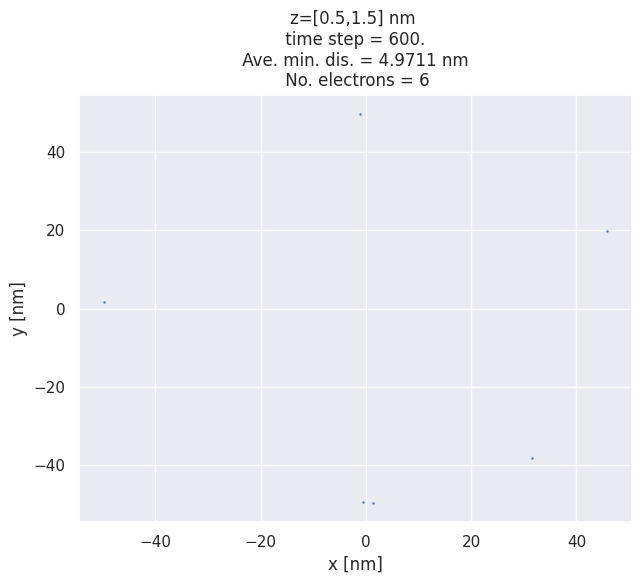

In [7]:
# tot_min=ave_min(sample_data)
# print(tot_min)

ring_levels = [1] # height of the ring in nm
ring_data =[None]*len(ring_levels)
dev = [0.5]*len(ring_levels) # deviation from the ring height in nm

fig = plt.figure(figsize=(18, 6))
for i, level in enumerate(ring_levels):
    dev_nm = dev[i]
    ring_data[i] = sample_data[(sample_data['z'] >= (level-dev_nm)*1e-9)&(sample_data['z'] <= (level+dev_nm)*1e-9)]
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(ring_data[i]['x']*1e9, ring_data[i]['y']*1e9, s=0.5)
    ax.set_xlabel('x [nm]')
    ax.set_ylabel('y [nm]')
    min_dis = ave_min(ring_data[i])
    ax.set_title(f'z=[{level-dev_nm},{level+dev_nm}] nm \n time step = {time_step}. \n Ave. min. dis. = {round(min_dis,4)} nm \n No. electrons = {len(ring_data[i])}')
plt.tight_layout()

<h3>Anode and cathode plot<h3>

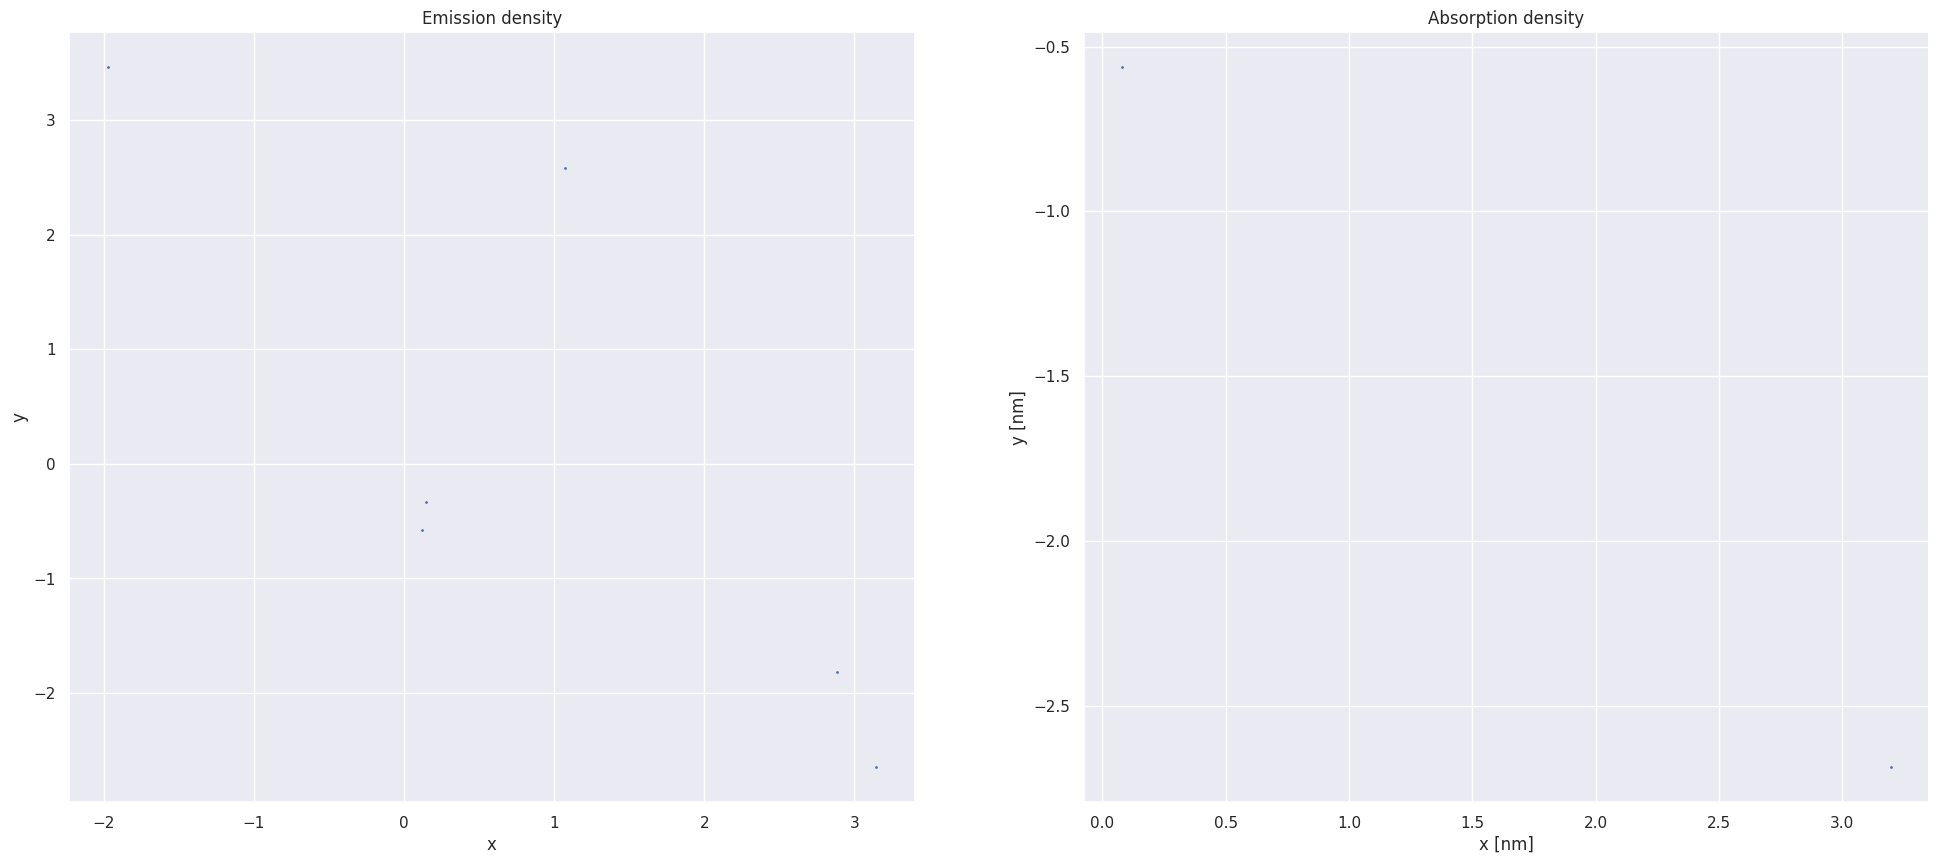

In [9]:

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import math

import seaborn as sns
sns.set_theme()

import os.path as path

# Emission density
fig2, axes = plt.subplots(1, 2, figsize=(24, 10))


filename = './out/density_emit_elec.bin'

# Binary file layout
# float64 (double precision numbers)
# int32 (32bit integers)
dt_emit_type = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64), ('emit', np.int64), ('nr', np.int64)])

# Memory map the file
# mode=r (Read only)
# order=F (Fortran style array)
data_mem_emit = np.memmap(filename, dtype=dt_emit_type, mode='r', order='F')
    
# Read the data into dataframe
df_emit = pd.DataFrame.from_records(data=data_mem_emit, columns=data_mem_emit.dtype.names)
    
# Add first joint plot (top right)
sns.scatterplot(data=df_emit, x="x", y="y", s=5, ax=axes[0])
axes[0].set_title('Emission density')

# Absorption density
filename = './out/density_absorb_top.bin'

# Binary file layout
# float64 (double precision numbers)
# int32 (32bit integers)
dt_abs_type = np.dtype([('x [nm]', np.float64), ('y [nm]', np.float64), ('vx', np.float64), ('vy', np.float64), ('vz', np.float64), ('emit', np.int64), ('sec', np.int64),  ('id', np.int64)])

# Memory map the file
# mode=r (Read only)
# order=F (Fortran style array)
data_mem_abs = np.memmap(filename, dtype=dt_abs_type, mode='r', order='F')
    
# Read the data into dataframe
sample_data = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)

# Add first joint plot (bottom right)
sns.scatterplot(data=sample_data, x="x [nm]", y="y [nm]", s=5, ax=axes[1])
axes[1].set_title('Absorption density')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.1)

# Show the plot
plt.show()